#Fake News Detection Using Logistic Regression and Convolutional Neural Networks

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import numpy as np
import spacy
import string
import sklearn
from sklearn.model_selection import train_test_split


In [ ]:
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import string

In [ ]:
!pip install keras-tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from kerastuner import HyperModel
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import tensorflow as tf
from tensorflow.keras.utils import plot_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 765.9 kB/s eta 0:00:00


<ipython-input-3-1ce6282d6374>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


## Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

true_csv_path = "/content/drive/My Drive/365Project/ISOT_dataset/True.csv"
fake_csv_path = "/content/drive/My Drive/365Project/ISOT_dataset/Fake.csv"

df_true = pd.read_csv(true_csv_path)
len_df_true = len(df_true)
df_fake = df_fake = pd.read_csv(fake_csv_path)
len_df_fake = len(df_fake)

data = {'Class': ['True', 'Fake'], 'Length': [len_df_true, len_df_fake]}
data = pd.DataFrame(data)
data.head()

Mounted at /content/drive


,Class,Length
0,True,21417
1,Fake,23481


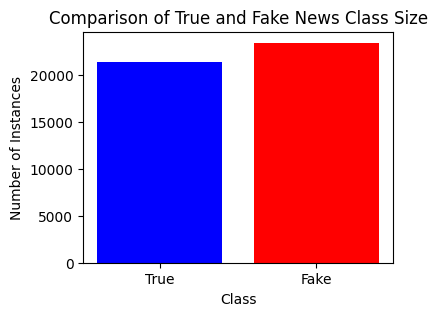

In [ ]:
plt.figure(figsize=(4, 3))
plt.bar(data['Class'], data['Length'], color=['blue', 'red'])
plt.title('Comparison of True and Fake News Class Size')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()

In [ ]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
count_reuters_true = df_true['text'].str.contains('Reuters', case=False, na=False).sum()

count_reuters_fake = df_fake['text'].str.contains('Reuters', case=False, na=False).sum()

print(f'Number of times "Reuters" is found in True news dataset: {count_reuters_true}')
print(f'Number of times "Reuters" is found in Fake news dataset: {count_reuters_fake}')

Number of times "Reuters" is found in True news dataset: 21378
Number of times "Reuters" is found in Fake news dataset: 322


In [ ]:
twitter_occurrences = df_fake['text'].str.contains('twitter.com').sum()
potus_occurrences = df_fake['text'].str.contains('@potus').sum()
dt_occurrences = df_fake['text'].str.contains('@realdonaldtrump').sum()
url_occurrences = df_fake['text'].str.count(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+').sum()

pattern1 = r'(?:\.\s*|\s)featured image via .*? images'
occurrences1 = df_fake['text'].str.contains(pattern1).sum()

pattern2 = r'(?:\.\s*| )featured image via .*? getty images(?: for.*?)?'
occurrences2 = df_fake['text'].str.contains(pattern2).sum()

pattern3 = r'featured image.*$'
occurrences3 = df_fake['text'].str.contains(pattern3).sum()

print(f"Occurrences of 'twitter.com': {twitter_occurrences}")
print(f"Occurrences of '@potus': {potus_occurrences}")
print(f"Occurrences of '@realdonaldtrump': {dt_occurrences}")
print(f"Occurrences of pattern1: {occurrences1}")
print(f"Occurrences of pattern2: {occurrences2}")
print(f"Occurrences of pattern3: {occurrences3}")
print(f"Occurrences of urls: {url_occurrences}")

Occurrences of 'twitter.com': 3615
Occurrences of '@potus': 8
Occurrences of '@realdonaldtrump': 57
Occurrences of pattern1: 0
Occurrences of pattern2: 0
Occurrences of pattern3: 36
Occurrences of urls: 4672


## Data Pre-processing

### Removing News Source From Text

In [ ]:
df_true['text'] = df_true['text'].str.replace(r'^.*?\(Reuters\)\s*-\s*', '', regex=True)

### Creating the main dataframe

In [ ]:
fake_df = df_fake[['title', 'text']]
true_df = df_true[['title', 'text']]

fake_df['class'] = 0
true_df['class'] = 1

df = pd.concat([fake_df, true_df], ignore_index=True, sort=False)
df['title_text'] = df['title'] + ' ' + df['text']
df.drop(['title', 'text'], axis=1, inplace=True)

df.head()

<ipython-input-11-436b98bf7589>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['class'] = 0
<ipython-input-11-436b98bf7589>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_df['class'] = 1


,class,title_text
0,0,Donald Trump Sends Out Embarrassing New Year’...
1,0,Drunk Bragging Trump Staffer Started Russian ...
2,0,Sheriff David Clarke Becomes An Internet Joke...
3,0,Trump Is So Obsessed He Even Has Obama’s Name...
4,0,Pope Francis Just Called Out Donald Trump Dur...


### Change Text to Lowercase

In [ ]:
def to_lowercase(text):
    return text.lower()

df['title_text'] = df['title_text'].apply(to_lowercase)

### Removing non-textual elements

In [ ]:
def remove_non_textual_elements(text):
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove markdown links - (http://url.com)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove specific patterns
    text = re.sub(r'featured image.*$', '', text)
    # remove 'twitter.com'
    text = re.sub(r'twitter\.com', '', text, flags=re.IGNORECASE)
    return text

df['title_text'] = df['title_text'].apply(remove_non_textual_elements)
df = df[~df['title_text'].str.contains('twitter.com')]

### Remove numbers & punctuation

In [ ]:
def remove_numbers_punctuation(text):
    return re.sub(r'\d+|[^a-zA-Z\s]', '', text)

df['title_text'] = df['title_text'].apply(remove_numbers_punctuation)

### Tokenize

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def tokenize(text):
    return word_tokenize(text)

df['tokens'] = df['title_text'].apply(tokenize)

### Remove stopwords

In [ ]:
stop_words = stopwords.words('english')

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['tokens'] = df['tokens'].apply(remove_stopwords)

### Stemming

In [ ]:
stemmer = PorterStemmer()

def stem(tokens):
    return [stemmer.stem(word) for word in tokens]

df['stemmed_tokens'] = df['tokens'].apply(stem)

### Join Stemmed Tokens

In [ ]:
def tokens_to_string(tokens):
    return ' '.join(tokens)

df['clean_text'] = df['stemmed_tokens'].apply(tokens_to_string)

In [ ]:
df = df[['class','clean_text']]
df.dropna(subset=['clean_text'], inplace=True)
df.head()

<ipython-input-20-9f83ff90a13f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['clean_text'], inplace=True)


,class,clean_text
0,0,donald trump send embarrass new year eve messa...
1,0,drunk brag trump staffer start russian collus ...
2,0,sheriff david clark becom internet joke threat...
3,0,trump obsess even obama name code websit imag ...
4,0,pope franci call donald trump christma speech ...


In [ ]:
df.to_csv('cleanedISOT.csv', index=False)

## Playing Around With Pre-trained Word Embedding Vectors

In [ ]:
np.random.seed(42)

In [ ]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys())) #available pre-trained word embedding models provided by the gensim api

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load('/content/drive/MyDrive/365Project/wv_300_vectors.kv') # Downloading the 300 dimensional Word2Vec Pre-trained Word Embedding Model

In [ ]:
wv.similarity("beard", "mustache")

0.8025587

In [ ]:
wv.similarity("beard", "pencil")

0.20437592

In [ ]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

vec_beard = wv['beard']
vec_mustache = wv['mustache']
vec_pencil = wv['pencil']

similarity_beard_mustache = cosine_similarity(vec_beard, vec_mustache)
similarity_beard_pencil = cosine_similarity(vec_beard, vec_pencil)

print("beard - mustache cosine similarity: " + str(similarity_beard_mustache))
print("beard - pencil cosine similarity: " + str(similarity_beard_pencil))

beard - mustache cosine similarity: 0.80255866
beard - pencil cosine similarity: 0.20437592


In [ ]:
wv.most_similar(positive=['car', 'minivan'], topn=5)

[('SUV', 0.8532192707061768),
 ('vehicle', 0.8175783753395081),
 ('pickup_truck', 0.7763688564300537),
 ('Jeep', 0.7567334175109863),
 ('Ford_Explorer', 0.7565720081329346)]

In [ ]:
wv.doesnt_match(['university', 'water', 'diploma', 'school', 'student', 'graduate'])

'water'

In [ ]:
wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951)]

### Visualizing the vectors

In [ ]:
words = ['university', 'water', 'basketball', 'school', 'student', 'liquid']

sample_vectors = np.array([wv[word] for word in words])
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(sample_vectors)
result

array([[-0.89875144, -0.86489093],
       [ 1.5242077 , -0.0194262 ],
       [-0.91139513,  2.4191253 ],
       [-0.91719323, -0.4183276 ],
       [-1.1542435 , -1.0551665 ],
       [ 2.3573756 , -0.06131356]], dtype=float32)

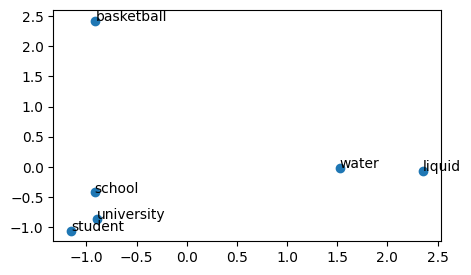

In [ ]:
plt.figure(figsize=(5,3))
plt.scatter(result[:,0], result[:,1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

## Applying Word Embedding on the Dataset for Logistic Regression

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/365Project/cleanedISOT.csv')
df.dropna(subset=['clean_text'], inplace=True)

In [ ]:
df['tokens'] = df['clean_text'].apply(lambda x: x.split())

In [ ]:
from scipy.sparse import csr_matrix

# sent_to_avg_vec: Takes the vectors for all the words in each text instance and combines it all in one vector by taking the average
def avg_vec(sent, wv, dim):
    valid_embeddings = [wv[word] for word in sent if word in wv]

    if valid_embeddings:
        avg_embedding = np.mean(valid_embeddings, axis=0)
    else:
        avg_embedding = np.zeros(dim)

    return avg_embedding

In [ ]:
# Here is an example case
dim = wv.vector_size
text = ["turkish", "football", "league"]
avg_vector = avg_vec(text, wv, dim)
avg_vector

array([-0.05354818, -0.00642904,  0.21223958,  0.06144206,  0.05013021,
       -0.1040802 ,  0.04701741, -0.17467754,  0.09830729,  0.20149739,
       -0.09488932, -0.17797852,  0.00264486,  0.14550781, -0.10994466,
        0.1648763 ,  0.03409831,  0.07230631,  0.1426595 , -0.00927734,
       -0.06005859,  0.08170573,  0.04695638, -0.13823445, -0.04353841,
       -0.01802317, -0.03792318,  0.27897134,  0.18286133,  0.19173177,
        0.04744466,  0.06453451,  0.1372884 , -0.06258138, -0.04817708,
        0.02244059,  0.15625   ,  0.00941976,  0.13232422,  0.18351237,
        0.1200358 , -0.10091146,  0.16194661,  0.16292317,  0.09699503,
       -0.13183594,  0.00716146, -0.14615886, -0.10913086,  0.15641277,
       -0.03441365, -0.02030436, -0.01794434,  0.07495117, -0.11067709,
       -0.2561442 ,  0.07942709, -0.02441406, -0.08854166, -0.0855306 ,
       -0.22916667,  0.0008138 , -0.06502279, -0.01554362,  0.05305989,
       -0.09680176,  0.04663086, -0.08119711,  0.1517334 ,  0.05

In [ ]:
df['avg_vector'] = df['tokens'].apply(lambda x: avg_vec(x, wv, wv.vector_size))

vectors_df = pd.DataFrame(df['avg_vector'].tolist())
result_df = pd.concat([df, vectors_df], axis=1)
result_df = result_df.drop(['avg_vector'], axis=1)

columns_to_check = list(range(0, 300)) + ['class']
df = result_df.dropna(subset=columns_to_check)

df.head()

<ipython-input-20-5b98cde2e316>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_vector'] = df['tokens'].apply(lambda x: avg_vec(x, wv, wv.vector_size))


,class,clean_text,tokens,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,0.0,donald trump send embarrass new year eve messa...,"[donald, trump, send, embarrass, new, year, ev...",0.008690,0.052507,0.028267,0.102293,-0.074369,0.009419,0.028947,...,0.059832,0.068490,-0.080953,-0.004112,-0.045639,-0.103846,-0.008104,-0.058081,-0.004457,0.018617
1,0.0,drunk brag trump staffer start russian collus ...,"[drunk, brag, trump, staffer, start, russian, ...",-0.027989,0.026530,0.016263,0.086592,-0.066898,0.005858,0.021110,...,0.041051,0.045733,-0.038417,0.032777,-0.042354,-0.068702,-0.014460,-0.076555,0.002295,0.029151
2,0.0,sheriff david clark becom internet joke threat...,"[sheriff, david, clark, becom, internet, joke,...",0.003965,0.022524,0.009441,0.068881,-0.057199,0.015096,0.012128,...,0.031391,0.053071,-0.072740,0.052704,-0.060610,-0.105792,-0.011891,-0.083825,-0.018013,0.038989
3,0.0,trump obsess even obama name code websit imag ...,"[trump, obsess, even, obama, name, code, websi...",0.004360,0.013982,0.036881,0.103634,-0.078380,-0.006526,0.041167,...,0.056276,0.049329,-0.034890,0.030771,-0.008382,-0.081602,0.005466,-0.107022,-0.028669,0.006137
4,0.0,pope franci call donald trump christma speech ...,"[pope, franci, call, donald, trump, christma, ...",0.026814,0.045902,0.031234,0.106746,-0.069552,0.001861,0.060818,...,-0.015138,0.040970,-0.092981,-0.012650,-0.034230,-0.018661,-0.033963,-0.042701,0.041217,0.024768


## PCA

In [ ]:
def standardize_data(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [ ]:
def compute_covariance_matrix(X):
    return np.cov(X, rowvar=False)

In [ ]:
def pca(X, num_components):

    X_std = standardize_data(X)

    covariance_matrix = compute_covariance_matrix(X_std)

    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    selected_eigenvectors = sorted_eigenvectors[:, :num_components]

    X_pca = np.dot(X_std, selected_eigenvectors)

    return X_pca

In [ ]:
feature_columns = [i for i in range(300)]
X = df[feature_columns].values

df_reduced = pca(X, num_components=2)
y_reduced = df['class'].values

df_reduced

array([[-6.9686691 , -3.35490097],
       [-2.457901  ,  2.47245576],
       [-8.32506832,  2.36309846],
       ...,
       [ 6.70632216, -6.21416062],
       [ 2.28497819,  4.70727509],
       [ 6.4799931 ,  4.66618335]])

## Logistic Regression

In [ ]:
def compute_gradient(X, y, b):
    intercept = np.ones((X.shape[0], 1))
    X_b = np.hstack((intercept, X))
    predictions = 1 / (1 + np.exp(-np.dot(X_b, b)))
    errors = y - predictions
    gradient = -np.dot(X_b.T, errors)
    return gradient

In [ ]:
def gradient_descent(X, y, initial_b, step_size, max_iteration):
    b = initial_b
    for iteration in range(max_iteration):
        gradient = compute_gradient(X, y, b)
        b -= step_size * gradient
    return b

In [ ]:
from sklearn.model_selection import train_test_split

def logistic_regression(X, y, step_sizes):
    X = np.asarray(X, dtype=np.float64)

    accuracies = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    max_iterations = 1000

    for step_size in step_sizes:
        initial_b = np.zeros(X_train.shape[1] + 1)
        optimized_b = gradient_descent(X_train, y_train, initial_b, step_size, max_iterations)

        intercept = np.ones((X_test.shape[0], 1))
        X_test_with_intercept = np.hstack((intercept, X_test))
        predicted_probabilities = 1 / (1 + np.exp(-np.dot(X_test_with_intercept, optimized_b)))
        predicted_labels = (predicted_probabilities > 0.5).astype(int)
        accuracy = calculate_accuracy(y_test, predicted_labels)
        accuracies.append((step_size, accuracy))

    return accuracies

In [ ]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    return correct_predictions / total_predictions

In [ ]:
step_sizes = [0.001, 0.01, 0.03, 0.05, 0.07]

# Original DataFrame
X = df[[i for i in range(300)]].values
y = df['class'].values
results_df = logistic_regression(X, y, step_sizes)

<ipython-input-41-4242b51176dc>:4: RuntimeWarning: overflow encountered in exp
  predictions = 1 / (1 + np.exp(-np.dot(X_b, b)))
<ipython-input-43-f4fd32a04c7d>:16: RuntimeWarning: overflow encountered in exp
  predicted_probabilities = 1 / (1 + np.exp(-np.dot(X_test_with_intercept, optimized_b)))


In [ ]:
# PCA-reduced DataFrame
results_df_reduced = logistic_regression(df_reduced, y_reduced, step_sizes)

<ipython-input-41-4242b51176dc>:4: RuntimeWarning: overflow encountered in exp
  predictions = 1 / (1 + np.exp(-np.dot(X_b, b)))
<ipython-input-43-f4fd32a04c7d>:16: RuntimeWarning: overflow encountered in exp
  predicted_probabilities = 1 / (1 + np.exp(-np.dot(X_test_with_intercept, optimized_b)))


In [ ]:
print("Results for Original DataFrame:")
for step_size, accuracy in results_df:
    print(f"Step Size: {step_size}, Accuracy: {accuracy}")

print("\nResults for PCA Reduced DataFrame:")
for step_size, accuracy in results_df_reduced:
    print(f"Step Size: {step_size}, Accuracy: {accuracy}")

Results for Original DataFrame:
Step Size: 0.001, Accuracy: 0.9381408827463219
Step Size: 0.01, Accuracy: 0.9344627730717788
Step Size: 0.03, Accuracy: 0.9379179670084707
Step Size: 0.05, Accuracy: 0.9381408827463219
Step Size: 0.07, Accuracy: 0.9324565314311191

Results for PCA Reduced DataFrame:
Step Size: 0.001, Accuracy: 0.8041685242978154
Step Size: 0.01, Accuracy: 0.8264600980829246
Step Size: 0.03, Accuracy: 0.8293580026749888
Step Size: 0.05, Accuracy: 0.8242309407044137
Step Size: 0.07, Accuracy: 0.832255907267053


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = df[[i for i in range(300)]]
Y = df['class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

classifier = LogisticRegression()
classifier.fit(X_train,Y_train)

predicted = classifier.predict(X_test)
print("sklearn Logistic Regression on Original Dataframe Accuracy :",metrics.accuracy_score(Y_test, predicted))


sklearn Logistic Regression on Original Dataframe Accuracy : 0.9400356665180561


## Data Analysis for CNN Modeling

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/365Project/cleanedISOT.csv')
df.dropna(subset=['clean_text'], inplace=True)

In [ ]:
df['word_count'] = df['clean_text'].apply(lambda text: len(text.split()))

word_count_stats = df['word_count'].describe()
word_count_stats

count    44869.000000
mean       235.299093
std        198.915992
min          3.000000
25%        124.000000
50%        208.000000
75%        292.000000
max       4849.000000
Name: word_count, dtype: float64

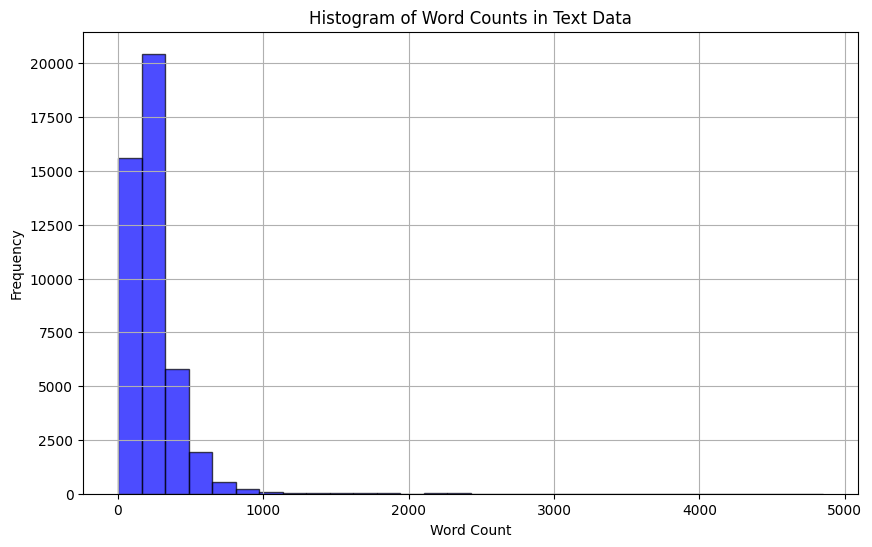

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Word Counts in Text Data')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
max_len_list = [df['word_count'].quantile(0.85), df['word_count'].quantile(0.9), df['word_count'].quantile(0.95)]
max_len_list

[369.0, 430.0, 527.0]

In [ ]:
texts = df['clean_text'].tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

num_unique_words = len(tokenizer.word_index)
num_unique_words

168818

## Introduction to CNN and its Parameters

### Adam Optimizer Algorithm

#### Gradient descent with learning rates (step sizes)

In [ ]:
def objective(x, y):
    return x**2 + y**2

def derivatives(x, y):
    dx = 2 * x
    dy = 2 * y
    return np.array([dx, dy])


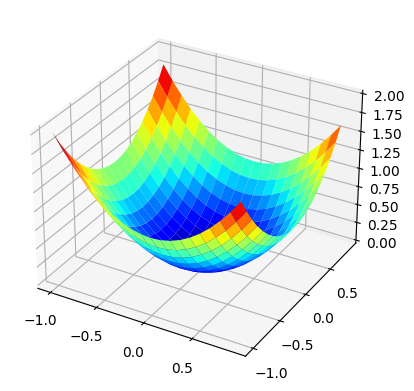

In [ ]:
from numpy import arange
from numpy import meshgrid

r_min, r_max = -1.0, 1.0
xaxis = arange(r_min, r_max, 0.1)
yaxis = arange(r_min, r_max, 0.1)

x, y = meshgrid(xaxis, yaxis)

results = objective(x, y)

figure = plt.figure()
axis = figure.add_subplot(111, projection='3d')  # Change here
axis.plot_surface(x, y, results, cmap='jet')

plt.show()

In [ ]:
def gradient_descent(start_point, learning_rate, n_iter):
    x, y = start_point
    trajectory = np.zeros((n_iter, 2))

    for i in range(n_iter):
        grad = derivatives(x, y)
        x -= learning_rate * grad[0]
        y -= learning_rate * grad[1]
        trajectory[i] = [x, y]
        print(f"Iteration {i}: Point=({x:.4f}, {y:.4f}), Objective={objective(x, y):.4f}")

    return x, y, trajectory

In [ ]:
start_point = (10, 10)  # Starting at (x=10, y=10)
n_iter = 20  # Number of iterations

# Experiment with learning rate 0.1
print("Experiment with learning rate 0.1")
final_x, final_y, trajectory_01 = gradient_descent(start_point, 0.1, n_iter)

# Experiment with learning rate 0.15
print("\nExperiment with learning rate 0.15")
final_x, final_y, trajectory_015 = gradient_descent(start_point, 0.15, n_iter)

Experiment with learning rate 0.1
Iteration 0: Point=(8.0000, 8.0000), Objective=128.0000
Iteration 1: Point=(6.4000, 6.4000), Objective=81.9200
Iteration 2: Point=(5.1200, 5.1200), Objective=52.4288
Iteration 3: Point=(4.0960, 4.0960), Objective=33.5544
Iteration 4: Point=(3.2768, 3.2768), Objective=21.4748
Iteration 5: Point=(2.6214, 2.6214), Objective=13.7439
Iteration 6: Point=(2.0972, 2.0972), Objective=8.7961
Iteration 7: Point=(1.6777, 1.6777), Objective=5.6295
Iteration 8: Point=(1.3422, 1.3422), Objective=3.6029
Iteration 9: Point=(1.0737, 1.0737), Objective=2.3058
Iteration 10: Point=(0.8590, 0.8590), Objective=1.4757
Iteration 11: Point=(0.6872, 0.6872), Objective=0.9445
Iteration 12: Point=(0.5498, 0.5498), Objective=0.6045
Iteration 13: Point=(0.4398, 0.4398), Objective=0.3869
Iteration 14: Point=(0.3518, 0.3518), Objective=0.2476
Iteration 15: Point=(0.2815, 0.2815), Objective=0.1585
Iteration 16: Point=(0.2252, 0.2252), Objective=0.1014
Iteration 17: Point=(0.1801, 0.180

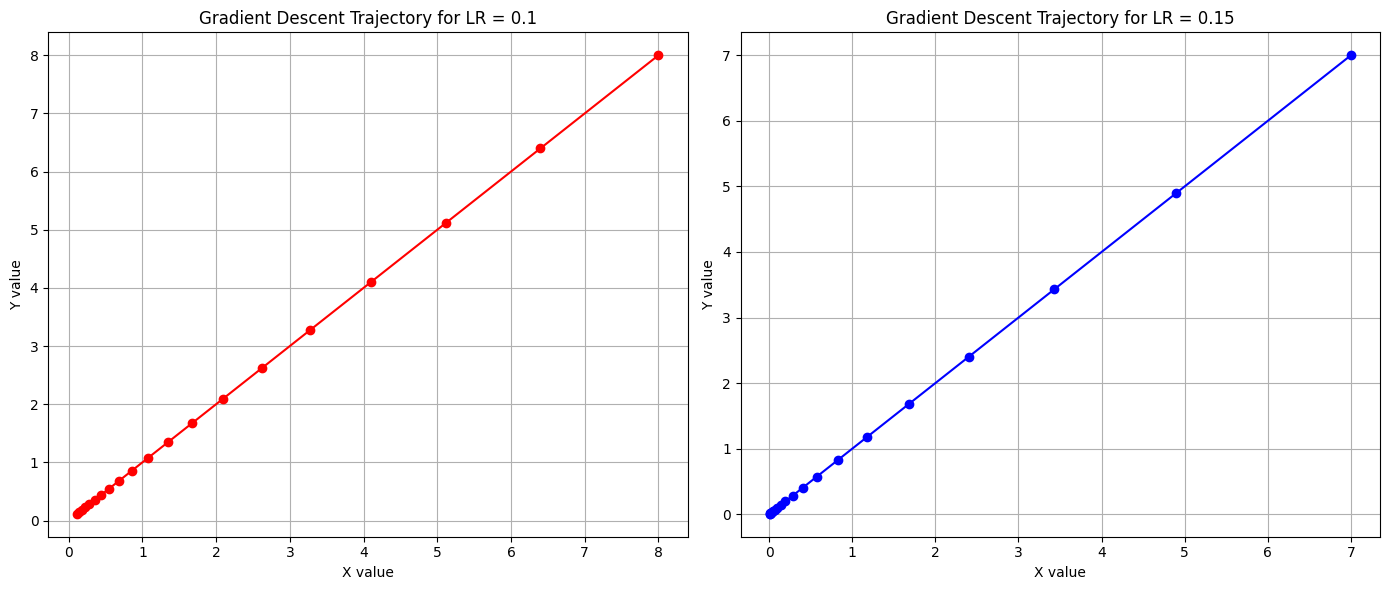

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# plot for learning rate = 0.1
axes[0].plot(trajectory_01[:, 0], trajectory_01[:, 1], 'ro-')
axes[0].set_title('Gradient Descent Trajectory for LR = 0.1')
axes[0].set_xlabel('X value')
axes[0].set_ylabel('Y value')
axes[0].grid(True)

# plot for learning rate = 0.15
axes[1].plot(trajectory_015[:, 0], trajectory_015[:, 1], 'bo-')
axes[1].set_title('Gradient Descent Trajectory for LR = 0.15')
axes[1].set_xlabel('X value')
axes[1].set_ylabel('Y value')
axes[1].grid(True)

# display side by side
plt.tight_layout()
plt.show()

#### Gradient descent with momentum

In [ ]:
def gradient_descent_with_momentum(start_point, learning_rate, beta, n_iter):
    x, y = start_point
    v_x = v_y = 0  # Initialize velocity components
    trajectory = np.zeros((n_iter, 2))

    for i in range(n_iter):
        grad = derivatives(x, y)
        v_x = beta * v_x + (1 - beta) * grad[0]
        v_y = beta * v_y + (1 - beta) * grad[1]
        x -= learning_rate * v_x
        y -= learning_rate * v_y
        trajectory[i] = [x, y]
        print(f"Iteration {i}: Point=({x:.4f}, {y:.4f}), Objective={objective(x, y):.4f}")

    return x, y, trajectory

In [ ]:
start_point = (10.0, 10.0)
learning_rate = 0.1
beta = 0.5
n_iter = 50

final_x, final_y, trajectory = gradient_descent_with_momentum(start_point, learning_rate, beta, n_iter)

Iteration 0: Point=(9.0000, 9.0000), Objective=162.0000
Iteration 1: Point=(7.6000, 7.6000), Objective=115.5200
Iteration 2: Point=(6.1400, 6.1400), Objective=75.3992
Iteration 3: Point=(4.7960, 4.7960), Objective=46.0032
Iteration 4: Point=(3.6444, 3.6444), Objective=26.5633
Iteration 5: Point=(2.7042, 2.7042), Objective=14.6250
Iteration 6: Point=(1.9636, 1.9636), Objective=7.7116
Iteration 7: Point=(1.3970, 1.3970), Objective=3.9032
Iteration 8: Point=(0.9740, 0.9740), Objective=1.8973
Iteration 9: Point=(0.6651, 0.6651), Objective=0.8846
Iteration 10: Point=(0.4441, 0.4441), Objective=0.3945
Iteration 11: Point=(0.2892, 0.2892), Objective=0.1673
Iteration 12: Point=(0.1829, 0.1829), Objective=0.0669
Iteration 13: Point=(0.1114, 0.1114), Objective=0.0248
Iteration 14: Point=(0.0645, 0.0645), Objective=0.0083
Iteration 15: Point=(0.0346, 0.0346), Objective=0.0024
Iteration 16: Point=(0.0162, 0.0162), Objective=0.0005
Iteration 17: Point=(0.0054, 0.0054), Objective=0.0001
Iteration 18

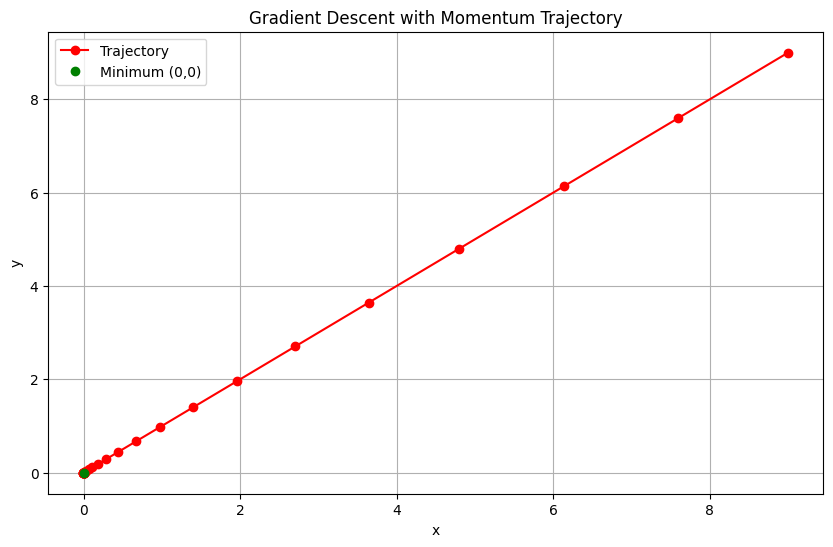

In [ ]:
x_coords, y_coords = trajectory[:, 0], trajectory[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_coords, y_coords, 'ro-', label='Trajectory')
plt.plot(0, 0, 'go', label='Minimum (0,0)')
plt.title('Gradient Descent with Momentum Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

#### Root Mean Squared Propagation

In [ ]:
def rmsprop(start_point, learning_rate, beta, epsilon, n_iter):
    x, y = start_point
    s_x = s_y = 0  # Initialize RMSProp accumulators
    trajectory = np.zeros((n_iter, 2))

    for i in range(n_iter):
        grad = derivatives(x, y)
        s_x = beta * s_x + (1 - beta) * grad[0]**2
        s_y = beta * s_y + (1 - beta) * grad[1]**2
        x -= (learning_rate / (np.sqrt(s_x) + epsilon)) * grad[0]
        y -= (learning_rate / (np.sqrt(s_y) + epsilon)) * grad[1]
        trajectory[i] = [x, y]
        print(f"Iteration {i}: Point=({x:.4f}, {y:.4f}), Objective={objective(x, y):.4f}")

    return x, y, trajectory

In [ ]:
start_point = (10.0, 10.0)
learning_rate = 0.25
beta = 0.5
epsilon = 1e-8
n_iter = 50

final_x, final_y, trajectory = rmsprop(start_point, learning_rate, beta, epsilon, n_iter)

Iteration 0: Point=(9.6464, 9.6464), Objective=186.1079
Iteration 1: Point=(9.3613, 9.3613), Objective=175.2678
Iteration 2: Point=(9.0990, 9.0990), Objective=165.5819
Iteration 3: Point=(8.8465, 8.8465), Objective=156.5209
Iteration 4: Point=(8.5988, 8.5988), Objective=147.8786
Iteration 5: Point=(8.3535, 8.3535), Objective=139.5635
Iteration 6: Point=(8.1096, 8.1096), Objective=131.5322
Iteration 7: Point=(7.8665, 7.8665), Objective=123.7637
Iteration 8: Point=(7.6239, 7.6239), Objective=116.2475
Iteration 9: Point=(7.3817, 7.3817), Objective=108.9781
Iteration 10: Point=(7.1398, 7.1398), Objective=101.9528
Iteration 11: Point=(6.8982, 6.8982), Objective=95.1701
Iteration 12: Point=(6.6569, 6.6569), Objective=88.6290
Iteration 13: Point=(6.4160, 6.4160), Objective=82.3289
Iteration 14: Point=(6.1753, 6.1753), Objective=76.2692
Iteration 15: Point=(5.9350, 5.9350), Objective=70.4495
Iteration 16: Point=(5.6951, 5.6951), Objective=64.8694
Iteration 17: Point=(5.4557, 5.4557), Objective

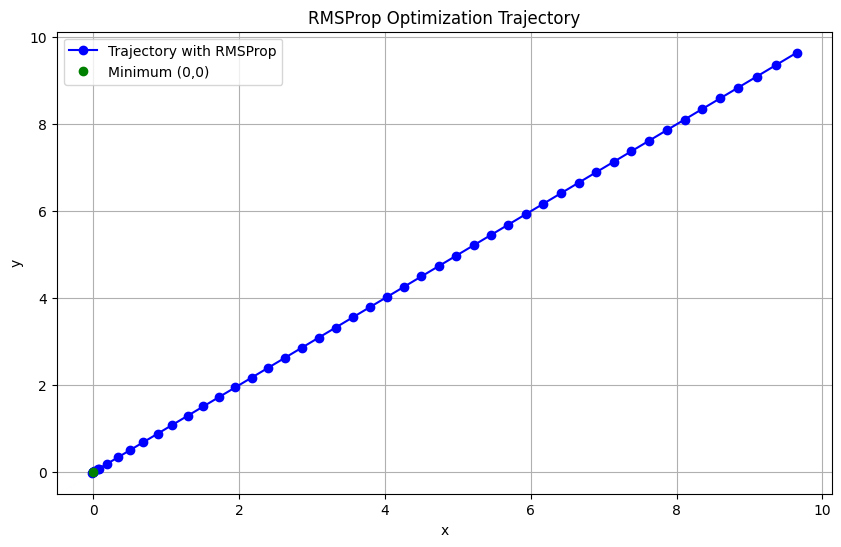

In [ ]:
x_coords, y_coords = trajectory[:, 0], trajectory[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_coords, y_coords, 'bo-', label='Trajectory with RMSProp')
plt.plot(0, 0, 'go', label='Minimum (0,0)')
plt.title('RMSProp Optimization Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

#### Root Mean Squared Propagation with Momentum

In [ ]:
def momentum_rmsprop(start_point, learning_rate, beta1, beta2, epsilon, n_iter):
    x, y = start_point
    v_x = v_y = 0  # momentum
    s_x = s_y = 0  # RMSProp
    trajectory = np.zeros((n_iter, 2))

    for i in range(n_iter):
        grad = derivatives(x, y)
        v_x = beta1 * v_x + (1 - beta1) * grad[0]
        v_y = beta1 * v_y + (1 - beta1) * grad[1]
        s_x = beta2 * s_x + (1 - beta2) * grad[0]**2
        s_y = beta2 * s_y + (1 - beta2) * grad[1]**2
        x -= (learning_rate / (np.sqrt(s_x) + epsilon)) * v_x
        y -= (learning_rate / (np.sqrt(s_y) + epsilon)) * v_y
        trajectory[i] = [x, y]
        print(f"Iteration {i}: Point=({x:.4f}, {y:.4f}), Objective={objective(x, y):.4f}")

    return x, y, trajectory


In [ ]:
start_point = (10.0, 10.0)
learning_rate = 0.4
beta1 = 0.7
beta2 = 0.9
epsilon = 1e-8
n_iter = 50

final_x, final_y, trajectory = momentum_rmsprop(start_point, learning_rate, beta1, beta2, epsilon, n_iter)

Iteration 0: Point=(9.6205, 9.6205), Objective=185.1091
Iteration 1: Point=(9.1537, 9.1537), Objective=167.5815
Iteration 2: Point=(8.6529, 8.6529), Objective=149.7452
Iteration 3: Point=(8.1429, 8.1429), Objective=132.6149
Iteration 4: Point=(7.6371, 7.6371), Objective=116.6499
Iteration 5: Point=(7.1426, 7.1426), Objective=102.0332
Iteration 6: Point=(6.6634, 6.6634), Objective=88.8028
Iteration 7: Point=(6.2016, 6.2016), Objective=76.9206
Iteration 8: Point=(5.7581, 5.7581), Objective=66.3109
Iteration 9: Point=(5.3330, 5.3330), Objective=56.8807
Iteration 10: Point=(4.9261, 4.9261), Objective=48.5327
Iteration 11: Point=(4.5371, 4.5371), Objective=41.1709
Iteration 12: Point=(4.1656, 4.1656), Objective=34.7041
Iteration 13: Point=(3.8110, 3.8110), Objective=29.0474
Iteration 14: Point=(3.4729, 3.4729), Objective=24.1226
Iteration 15: Point=(3.1510, 3.1510), Objective=19.8578
Iteration 16: Point=(2.8449, 2.8449), Objective=16.1873
Iteration 17: Point=(2.5544, 2.5544), Objective=13.0

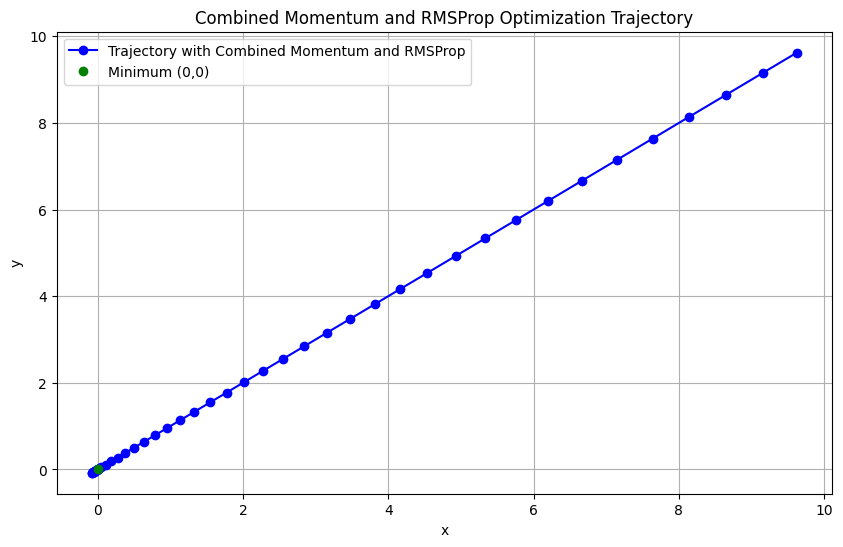

In [ ]:
x_coords, y_coords = trajectory[:, 0], trajectory[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_coords, y_coords, 'bo-', label='Trajectory with Combined Momentum and RMSProp')
plt.plot(0, 0, 'go', label='Minimum (0,0)')  # Mark the minimum
plt.title('Combined Momentum and RMSProp Optimization Trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

#### Adam Algorithm

In [ ]:
def adam(start_point, learning_rate, beta1, beta2, epsilon, n_iter):
    x, y = start_point
    m_x = m_y = 0  # First moment vector
    v_x = v_y = 0  # Second moment vector
    trajectory = np.zeros((n_iter, 2))

    for i in range(1, n_iter + 1):
        grad = derivatives(x, y)
        m_x = beta1 * m_x + (1 - beta1) * grad[0]
        m_y = beta1 * m_y + (1 - beta1) * grad[1]
        v_x = beta2 * v_x + (1 - beta2) * grad[0]**2
        v_y = beta2 * v_y + (1 - beta2) * grad[1]**2
        m_hat_x = m_x / (1 - beta1**i)
        m_hat_y = m_y / (1 - beta2**i)
        v_hat_x = v_x / (1 - beta2**i)
        v_hat_y = v_y / (1 - beta2**i)
        x -= (learning_rate / (np.sqrt(v_hat_x) + epsilon)) * m_hat_x
        y -= (learning_rate / (np.sqrt(v_hat_y) + epsilon)) * m_hat_y
        trajectory[i - 1] = [x, y]
        print(f"Iteration {i}: Point=({x:.4f}, {y:.4f}), Objective={objective(x, y):.4f}")

    return x, y, trajectory

In [ ]:
params = [
    {'lr': 0.01, 'beta1': 0.2, 'beta2': 0.999},
    {'lr': 0.04, 'beta1': 0.7, 'beta2': 0.995},
    {'lr': 0.07, 'beta1': 0.9, 'beta2': 0.999}
]

start_point = (3.0, 3.0)
epsilon = 1e-8
n_iter = 50

Iteration 1: Point=(2.9900, -5.0000), Objective=33.9401
Iteration 2: Point=(2.9800, -0.7297), Objective=9.4130
Iteration 3: Point=(2.9700, 0.5369), Objective=9.1094
Iteration 4: Point=(2.9601, 0.3909), Objective=8.9149
Iteration 5: Point=(2.9501, 0.1277), Objective=8.7196
Iteration 6: Point=(2.9402, 0.0089), Objective=8.6449
Iteration 7: Point=(2.9303, -0.0177), Objective=8.5870
Iteration 8: Point=(2.9204, -0.0142), Objective=8.5290
Iteration 9: Point=(2.9105, -0.0071), Objective=8.4713
Iteration 10: Point=(2.9007, -0.0027), Objective=8.4140
Iteration 11: Point=(2.8908, -0.0007), Objective=8.3570
Iteration 12: Point=(2.8810, -0.0001), Objective=8.3003
Iteration 13: Point=(2.8712, 0.0001), Objective=8.2439
Iteration 14: Point=(2.8614, 0.0001), Objective=8.1877
Iteration 15: Point=(2.8517, 0.0001), Objective=8.1319
Iteration 16: Point=(2.8419, 0.0000), Objective=8.0764
Iteration 17: Point=(2.8322, 0.0000), Objective=8.0211
Iteration 18: Point=(2.8224, 0.0000), Objective=7.9662
Iteration 

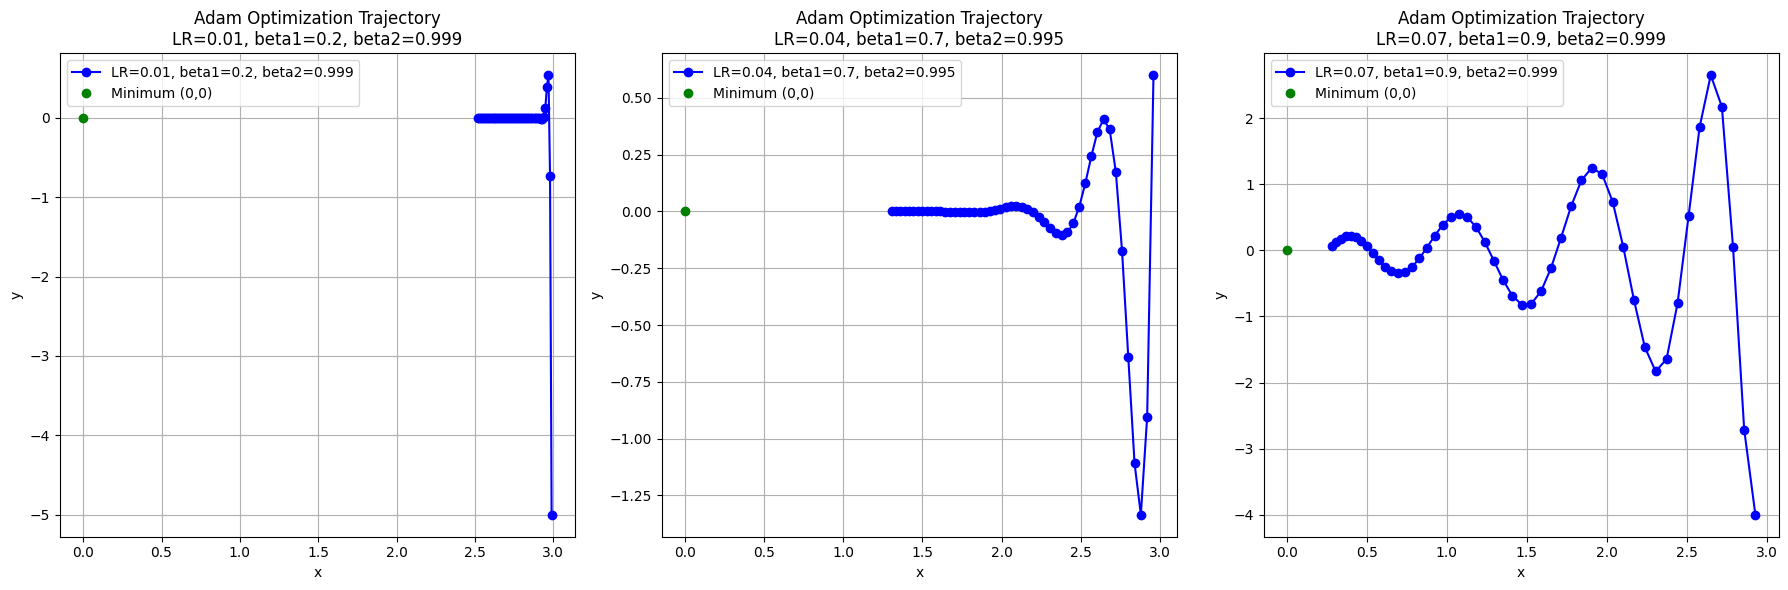

In [ ]:
fig, axes = plt.subplots(1, len(params), figsize=(18, 6))
for i, param in enumerate(params):
    _, _, trajectory = adam(start_point, param['lr'], param['beta1'], param['beta2'], epsilon, n_iter)
    axes[i].plot(trajectory[:, 0], trajectory[:, 1], 'bo-', label=f"LR={param['lr']}, beta1={param['beta1']}, beta2={param['beta2']}")
    axes[i].plot(0, 0, 'go', label='Minimum (0,0)')
    axes[i].set_title(f"Adam Optimization Trajectory\nLR={param['lr']}, beta1={param['beta1']}, beta2={param['beta2']}")
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

### Binary Cross Entropy

In [ ]:
def binary_cross_entropy(y_true, y_pred):
    # avoid division by zero
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)

    return -y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred) # formula for binary cross entropy

In [ ]:
predictions = np.linspace(0, 1, 400)

# True label = 1
loss_when_true = binary_cross_entropy(1, predictions)

# True label = 0
loss_when_false = binary_cross_entropy(0, predictions)

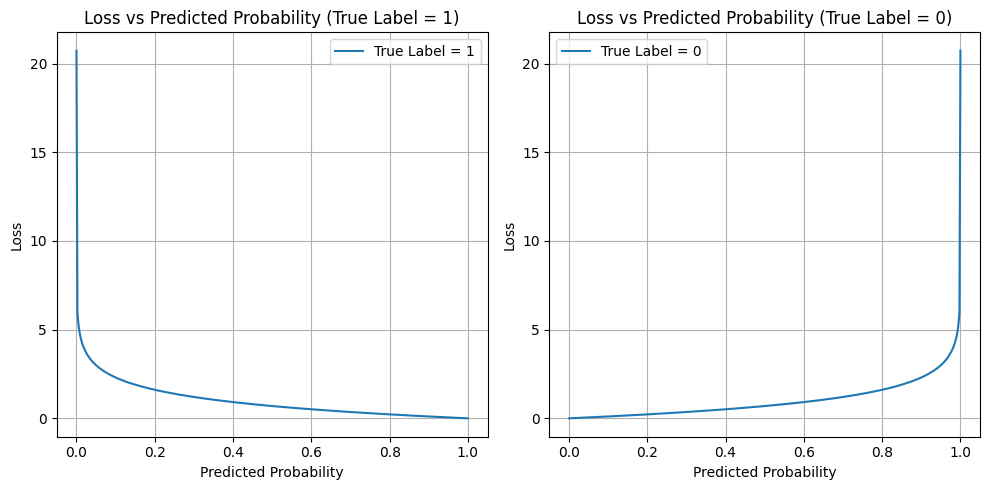

In [ ]:
plt.figure(figsize=(10, 5))

# Plot for true label = 1
plt.subplot(1, 2, 1)
plt.plot(predictions, loss_when_true, label='True Label = 1')
plt.title('Loss vs Predicted Probability (True Label = 1)')
plt.xlabel('Predicted Probability')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot for true label = 0
plt.subplot(1, 2, 2)
plt.plot(predictions, loss_when_false, label='True Label = 0')
plt.title('Loss vs Predicted Probability (True Label = 0)')
plt.xlabel('Predicted Probability')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Rectified Linear Unit, Relu Activation Function

In [ ]:
from ipywidgets import interact

def relu(x):
    return np.maximum(0, x)

def plot_relu(x_range):
    x = np.linspace(-x_range, x_range, 400)
    y = relu(x)

    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label='ReLU: max(0, x)', linewidth=2)
    plt.title('ReLU Activation Function')
    plt.xlabel('Input (x)')
    plt.ylabel('Output (ReLU(x))')
    plt.grid(True)
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.legend()
    plt.show()

interact(plot_relu, x_range=(1, 10));

interactive(children=(IntSlider(value=5, description='x_range', max=10, min=1), Output()), _dom_classes=('widg…

In [ ]:
from sklearn.datasets import make_circles
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# generate synthetic data
X, y = make_circles(n_samples=100, factor=0.5, noise=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a model using ReLU
model_relu = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, activation='relu', random_state=1)
model_relu.fit(X_train, y_train)

accuracy_relu = accuracy_score(y_test, model_relu.predict(X_test))

print(f"Accuracy with ReLU: {accuracy_relu:.2f}")

Accuracy with ReLU: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


### Sigmoid Activation Function

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plot_sigmoid(x_range):
    x = np.linspace(-x_range, x_range, 400)
    y = sigmoid(x)

    plt.figure(figsize=(10, 5))
    plt.plot(x, y, label='Sigmoid: 1 / (1 + exp(-x))', linewidth=2)
    plt.title('Sigmoid Activation Function')
    plt.xlabel('Input (x)')
    plt.ylabel('Output (Sigmoid(x))')
    plt.grid(True)
    plt.axhline(0, color='gray', lw=0.5)
    plt.axhline(1, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.legend()
    plt.show()

interact(plot_sigmoid, x_range=(1, 10));

interactive(children=(IntSlider(value=5, description='x_range', max=10, min=1), Output()), _dom_classes=('widg…

In [ ]:
X, y = make_circles(n_samples=100, factor=0.5, noise=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train a model using Sigmoid
model_sigmoid = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, activation='logistic', random_state=1)
model_sigmoid.fit(X_train, y_train)

accuracy_sigmoid = accuracy_score(y_test, model_sigmoid.predict(X_test))

print(f"Accuracy with Sigmoid: {accuracy_sigmoid:.2f}")

Accuracy with Sigmoid: 0.43


### Layers in Neural Networks

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 430, 300)          3000000   
 )                                                               
                                                                 
 conv1d_layer (Conv1D)       (None, 428, 128)          115328    
                                                                 
 max_pooling1d_layer (MaxPo  (None, 85, 128)           0         
 oling1D)                                                        
                                                                 
 flatten_layer (Flatten)     (None, 10880)             0         
                                                                 
 dense_layer (Dense)         (None, 128)               1392768   
                                                                 
 output_layer (Dense)        (None, 1)                 1

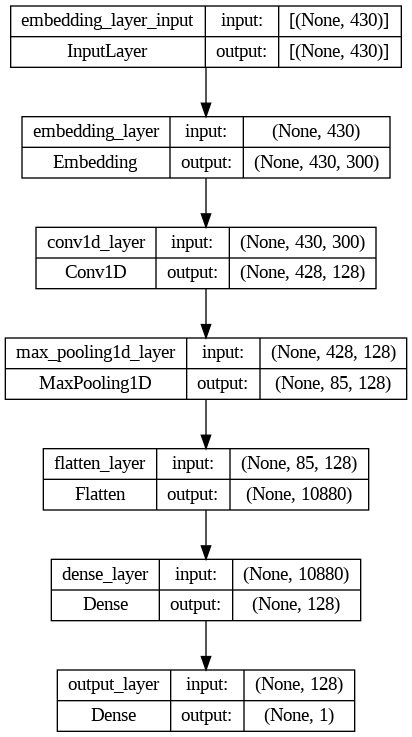

In [ ]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=300, input_length=430, name='embedding_layer'),
    Conv1D(filters=128, kernel_size=3, activation='relu', name='conv1d_layer'),
    MaxPooling1D(pool_size=5, name='max_pooling1d_layer'),
    Flatten(name='flatten_layer'),
    Dense(128, activation='relu', name='dense_layer'),
    Dense(1, activation='sigmoid', name='output_layer')
])

model.summary()

plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.models import Model

sample_input = np.random.randint(10000, size=(1, 430))

# a model that outputs from each layer
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# the outputs for each layer
activations = activation_model.predict(sample_input)


1/1 [==============================] - 0s 407ms/step


In [ ]:
def plot_layer_activations(layer_activations, layer_names):
    plt.figure(figsize=(10, 8))
    for i, activation in enumerate(layer_activations):
        plt.subplot(len(layer_activations), 1, i+1)
        plt.title(layer_names[i])
        if activation.ndim > 2:  # Not flatten or dense layer
            plt.imshow(activation[0, :, :], aspect='auto', cmap='viridis')
        else:  # Flatten or dense layer
            plt.plot(activation[0, :], '.-')
        plt.grid(False)
    plt.tight_layout()
    plt.show()

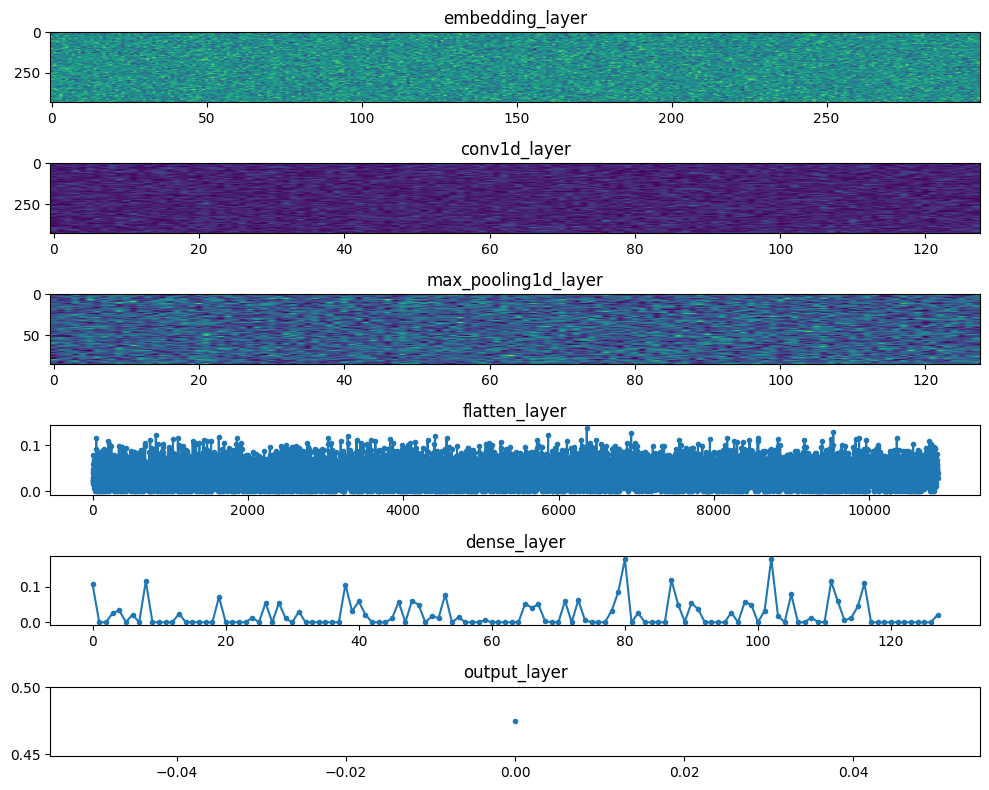

In [ ]:
layer_names = [layer.name for layer in model.layers]
plot_layer_activations(activations, layer_names)

### Training and Validation Loss & Accuracy Values

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# generate synthetic binary classification data
np.random.seed(0)
data = np.random.randn(1000, 20)
labels = np.random.randint(2, size=(1000, 1))

X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    Dense(64, activation='relu', input_shape=(20,), kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[callback],
                    verbose=0)


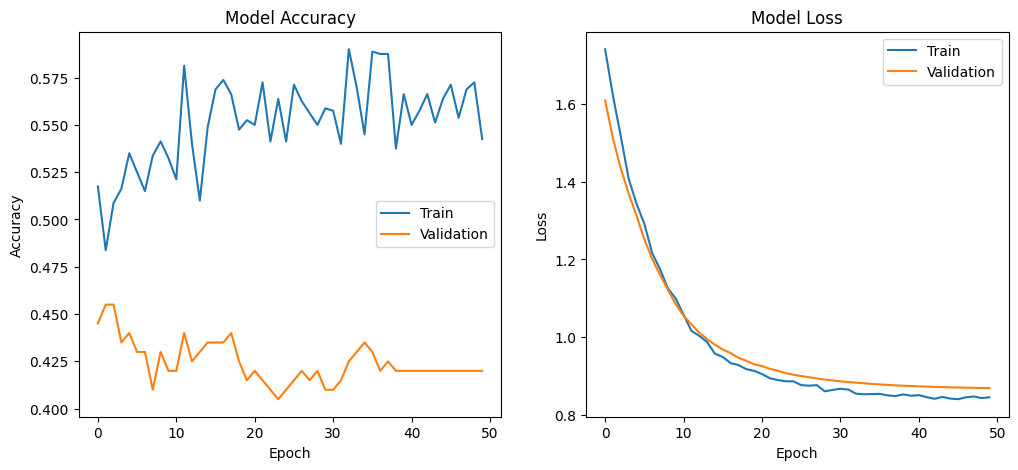

In [ ]:
# training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Create Word Embedding Matrix for CNN

In [ ]:
texts = df['clean_text'].tolist()
labels_cnn = df['class'].values

In [ ]:
num_words_list = [20000, 25000, 30000, 35000, 40000]
tokenizer = Tokenizer(num_words=35000)  # Only the top 35000 words will be kept
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) # list of lists where each integer represents one of the top 35000 words

sequences[:1] # The first text instance represented as a series of integers

[[21,
  1,
  678,
  1290,
  12,
  11,
  3531,
  458,
  1915,
  21,
  1,
  1430,
  36,
  1450,
  12,
  11,
  289,
  541,
  164,
  2098,
  1392,
  4626,
  3635,
  587,
  44,
  68,
  58,
  879,
  63,
  858,
  10,
  177,
  27,
  3568,
  832,
  2422,
  7433,
  47,
  1430,
  531,
  25,
  1392,
  4626,
  54,
  3635,
  587,
  44,
  68,
  1450,
  3267,
  12,
  11,
  5,
  1414,
  4320,
  220,
  325,
  11,
  90,
  27,
  3568,
  832,
  2422,
  7433,
  47,
  1430,
  531,
  25,
  1392,
  4626,
  54,
  3635,
  587,
  44,
  68,
  1450,
  3267,
  12,
  11,
  325,
  11,
  90,
  21,
  811,
  1,
  610,
  1,
  220,
  364,
  627,
  5,
  678,
  12,
  11,
  3459,
  17,
  4963,
  4381,
  16633,
  19455,
  1,
  957,
  5481,
  54,
  165,
  817,
  9649,
  279,
  455,
  1430,
  36,
  423,
  1450,
  12,
  11,
  3866,
  13935,
  610,
  10,
  17,
  14502,
  610,
  1624,
  6,
  34,
  325,
  11,
  90,
  13,
  588,
  4287,
  246,
  131,
  9239,
  610,
  355,
  98,
  48,
  66,
  7,
  465,
  1096,
  465,
  4288,
  11575,


In [ ]:
max_len = 430
X_padded = pad_sequences(sequences, maxlen=max_len)

# embedding matrix
vocab_size = min(len(tokenizer.word_index) + 1, 35001)
embedding_dim = wv.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        try:
            embedding_vector = wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        except KeyError:
            continue

In [ ]:
print("Shape of embedding matrix:", embedding_matrix.shape)
print("Sample values from the embedding matrix:\n", embedding_matrix[1:10])

Shape of embedding matrix: (35001, 300)
Sample values from the embedding matrix:
 [[-0.07910156  0.12158203 -0.00842285 ... -0.39257812  0.07763672
   0.27148438]
 [-0.00909424 -0.04418945  0.09960938 ...  0.14453125  0.18066406
  -0.08691406]
 [ 0.02990723  0.05639648  0.0037384  ... -0.02416992  0.01086426
  -0.14746094]
 ...
 [ 0.04052734 -0.07324219  0.06201172 ... -0.04614258 -0.09570312
  -0.02050781]
 [-0.03613281 -0.12109375  0.13378906 ... -0.08642578  0.14355469
   0.02734375]
 [-0.03393555 -0.17871094  0.09033203 ... -0.05078125  0.17285156
   0.29492188]]


## Building the CNN Model and HyperParameter Tuning for the Dataset

In [ ]:
texts = df['clean_text'].tolist()
labels_cnn = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(X_padded, labels_cnn, test_size=0.2, random_state=42)

In [ ]:
print(X_train[0])
print(y_train[0])

print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)

print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

class CNNHyperModel(HyperModel):
    def __init__(self, vocab_size, embedding_dim, max_len, embedding_matrix):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_len = max_len
        self.embedding_matrix = embedding_matrix

    def build(self, hp):
        model = Sequential()
        model.add(Embedding(self.vocab_size, self.embedding_dim,
                            weights=[self.embedding_matrix],
                            input_length=self.max_len,
                            trainable=False))
        model.add(Conv1D(
            filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('conv_1_kernel_size', values=[3, 5, 7]),
            padding='same',
            activation='relu'))
        model.add(MaxPooling1D(
            pool_size=hp.Choice('max_pool_1_size', values=[2, 5, 7])))
        model.add(Flatten())
        model.add(Dense(
            units=hp.Int('dense_1_units', min_value=64, max_value=256, step=32),
            activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', Precision(), Recall()])
        return model

In [ ]:
tuner = RandomSearch(
    hypermodel=CNNHyperModel(vocab_size, embedding_dim, max_len, embedding_matrix),
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_tuner_cnn')

tuner.search(x=X_train, y=y_train,
             epochs=7,
             batch_size=128,
             validation_data=(X_test, y_test),
             verbose=2)

Reloading Tuner from my_dir/keras_tuner_cnn/tuner0.json


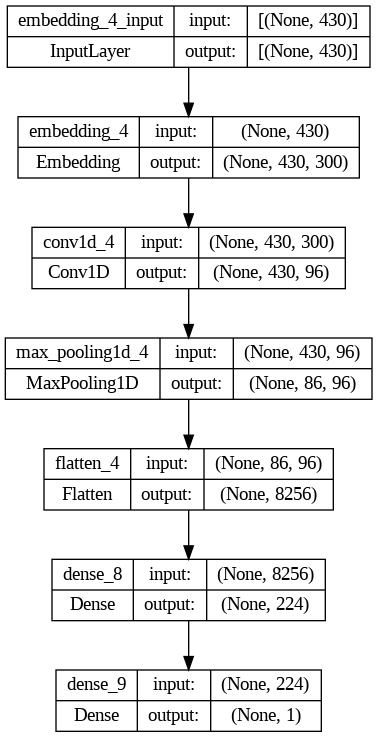

In [ ]:
from IPython.display import Image

best_model = CNNHyperModel(vocab_size, embedding_dim, max_len, embedding_matrix).build(best_hps)

best_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy', Precision(), Recall()])

plot_model(best_model, to_file='best_model_architecture.png', show_shapes=True, show_layer_names=True)

Image(filename='best_model_architecture.png')

In [ ]:
# get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print('Best hyperparameters found:\n')
print(f"Best number of filters in the first Conv1D layer: {best_hps.get('conv_1_filters')}")
print(f"Best kernel size for the first Conv1D layer: {best_hps.get('conv_1_kernel_size')}")
print(f"Best pooling size for the first MaxPooling1D layer: {best_hps.get('max_pool_1_size')}")
print(f"Best number of units in the first Dense layer: {best_hps.get('dense_1_units')}")

Best hyperparameters found:

Best number of filters in the first Conv1D layer: 96
Best kernel size for the first Conv1D layer: 7
Best pooling size for the first MaxPooling1D layer: 5
Best number of units in the first Dense layer: 224


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

best_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy', Precision(), Recall()])

results = best_model.evaluate(X_test, y_test, verbose=0)

print(f"Accuracy: {results[1]*100:.2f}%")
print(f"Precision: {results[2]*100:.2f}%")
print(f"Recall: {results[3]*100:.2f}%")

f1_score = 2 * (results[2] * results[3]) / (results[2] + results[3])
print(f"F1 Score: {f1_score:.2f}%")

Accuracy: 98.57%
Precision: 98.73%
Recall: 98.27%
F1 Score: 0.98%


281/281 [==============================] - 64s 226ms/step


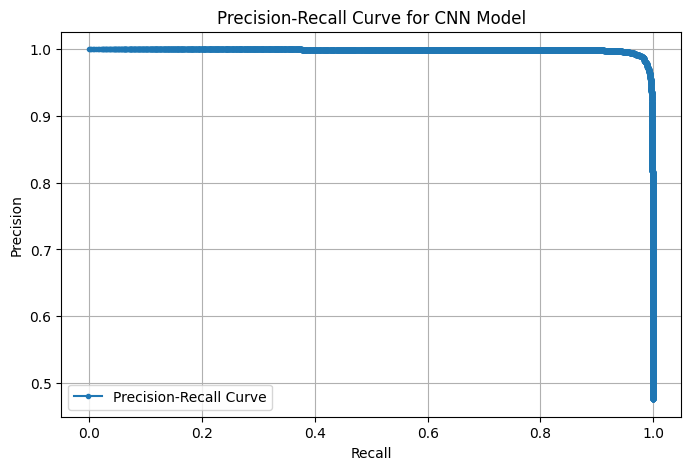

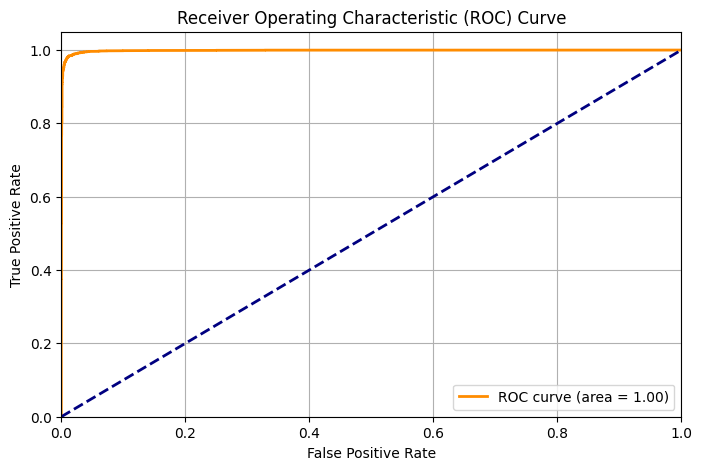

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

y_pred_prob = best_model.predict(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for CNN Model')
plt.legend()
plt.grid(True)
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99      4707
     Class 1       0.99      0.98      0.98      4267

    accuracy                           0.99      8974
   macro avg       0.99      0.99      0.99      8974
weighted avg       0.99      0.99      0.99      8974



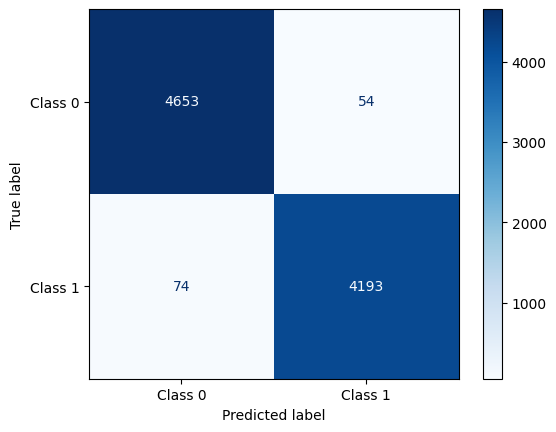

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')
plt.show()

In [ ]:
misclassified_indices = np.where(y_pred.flatten() != y_test)[0]
misclassified_texts = [texts[i] for i in misclassified_indices]
misclassified_probs = y_pred_prob[misclassified_indices]
actual_labels = y_test[misclassified_indices]

for i in range(min(20, len(misclassified_texts))):
    print(f"Text: {misclassified_texts[i]}")
    print(f"Predicted Prob: {misclassified_probs[i][0]}, Actual Label: {actual_labels[i]}\n")

Text: ohio fireman deep sht horribl remark save ns firefight ohio recent came fire express econom uncertainti synonym media concoct racism attempt explain peopl vote trump rescu black peopleif came choos rescu singl dog million ngger franklin township firefight tyler roysdon say would save dog import africanamerican hatesaccord roysdon facebook like fan donald trump duck dynasti farright facebook group uncl sam misguid children know sort person deal withroysdon suspend posit indefinit soon township offici learn post went viral social media happen terribl peopl say terribl thing also like lose job accord statement offici recent franklin township volunt firefight post unaccept remark social media upon gain knowledg inform fire chief steve bishop immedi contact firefight direct comment remov firefight suspend without pay board township truste could meet determin cours action chief bishop author termin employe termin township employe requir vote board truste unclear roysdon racism ever aff

In [ ]:
from collections import Counter

misclassified_words = []
for text in misclassified_texts:
    misclassified_words.extend(text.split())

word_freq = Counter(misclassified_words)
print(word_freq.most_common(20))

[('trump', 816), ('peopl', 183), ('donald', 178), ('presid', 164), ('would', 154), ('one', 149), ('say', 148), ('like', 146), ('said', 146), ('go', 137), ('republican', 136), ('state', 130), ('even', 121), ('make', 111), ('get', 107), ('time', 105), ('know', 103), ('want', 99), ('right', 98), ('us', 93)]


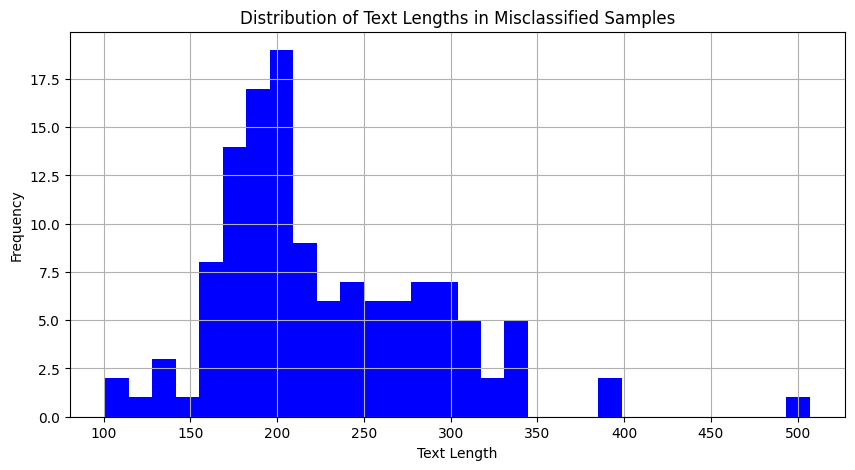

In [ ]:
misclassified_lengths = [len(text.split()) for text in misclassified_texts]
plt.figure(figsize=(10, 5))
plt.hist(misclassified_lengths, bins=30, color='blue')
plt.title('Distribution of Text Lengths in Misclassified Samples')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
word_text_count = {}

for text in misclassified_texts:
    unique_words = set(text.split())
    for word in unique_words:
        if word in word_text_count:
            word_text_count[word] += 1
        else:
            word_text_count[word] = 1

# sort the words based on the number of texts they appear in
sorted_word_text_count = sorted(word_text_count.items(), key=lambda item: item[1], reverse=True)

# the top 20 words that appear in the most texts
print("Top 20 words that appear in the most misclassified texts:")
for word, count in sorted_word_text_count[:20]:
    print(f"{word}: {count}")

Top 20 words that appear in the most misclassified texts:
trump: 99
donald: 85
one: 82
say: 76
said: 75
peopl: 74
go: 74
like: 71
make: 71
would: 70
time: 68
even: 67
presid: 64
state: 62
get: 61
right: 60
us: 58
think: 57
want: 56
new: 56
